<a href="https://colab.research.google.com/github/atreyat12/Image_Classification_XAI/blob/main/AT_XAI_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #5 - Deep Learning
### Identifying focus points for image classification - Explainability
### Atreya Tadepalli

#### Include the button below. Change the link to the location in your github repository:
#### Example: https://colab.research.google.com/github/yourGHName/yourREPOName/blob/yourBranchName/yourFileName.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1exWOLTDwcez3ANSfxtP28ntcCIuFV5t9?usp=sharing)

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Image_Classification_XAI" # Change to your repo name
git_path = 'https://github.com/atreyat12/Image_Classification_XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

#### Using environment variables in Google Colab

In Google Colab, locate the key button on the left side of the screen. You can enter in any environment variables or API keys here and they will remain private.

Then add the environment variables to your notebook using the code below.

Make sure to document in your notebook if you are using API keys and how to get them (ie share a link for documentation to get a Hugging Face API Key if you are using Hugging Face)

In [ ]:
from google.colab import userdata
userdata.get('secretName')

## Introduction

The dataset I chose to focus on comes from Kaggle, and concerns the health of coral reefs. Specifically, the dataset contains 932 images, with an approximately even split into healthy and bleached corals. The aim is that with such a dataset and a well-trained image classifier, we can improve detection of bleached corals and better track the status of one of Earth's most vital organisms which helps foster so much underwater biodiversity. I also believe that with a such a tool that can emphasize the decision points used by a classifier to classify a coral, the important markers of a coral's health can perhaps be restored as part of conservation efforts.

In this exercise, we are able to use a pre-trained image classifier. However, it does not distinguish between healthy and bleached coral. I see per the below guide that coral is a class of images upon which ResNet50 is trained, but perhaps it only classifies as a coral, and not a healthy or bleached coral. Therefore, I will slightly modify the final layer of ResNet50 here.
https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

Given this involves GradCAM and its variants, I will install the GradCAM package.

In [ ]:
pip install gradcam

ERROR: Could not find a version that satisfies the requirement gradcam (from versions: none)
ERROR: No matching distribution found for gradcam


In [ ]:
###Load Packages
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import kagglehub
import numpy as np
from torchvision.utils import make_grid
import random

from pytorch_grad_cam import GradCAM, LayerCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

### Load Dataset of Images

In order to load the dataset, I use the Kaggle documentation when downloading, and copy that documentation directly here. I also check the file structure within the path.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("vencerlanz09/healthy-and-bleached-corals-image-classification")

print("Path to dataset files:", path)

100%|██████████| 25.8M/25.8M [00:00<00:00, 202MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification/versions/1


In [ ]:
print(os.listdir(path))

['bleached_corals', 'healthy_corals']


In order to train and test this, I will need to split the files into training and testing samples. Given we are asked to apply explainability techniques to 5 images, I will choose to reduce the testing sample to just 10% of the overall sample size. This will allow for increased training on the dataset. I use a script provided by ChatGPT in order to divide the samples into training and testing, and also to develop a transformation of the image into 224 by 224 pixels, and preparing this as a Tensor.

In [ ]:
# Your dataset path
original_path = path  # from kagglehub
output_base = "/content/data"  # where we’ll store train/test splits
os.makedirs(output_base, exist_ok=True)

# Classes
classes = ['healthy_corals', 'bleached_corals']

for class_name in classes:
    class_dir = os.path.join(original_path, class_name)
    images = os.listdir(class_dir)

    train_imgs, test_imgs = train_test_split(images, test_size=0.1, random_state=42)

    for split, split_imgs in [('train', train_imgs), ('test', test_imgs)]:
        split_dir = os.path.join(output_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)

        for img_name in split_imgs:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_dir, img_name)
            shutil.copy(src, dst)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(os.path.join(output_base, 'train'), transform=transform)
test_dataset   = datasets.ImageFolder(os.path.join(output_base, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=16, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['bleached_corals', 'healthy_corals']


In [ ]:
print(os.listdir(original_path))

['healthy_corals', 'bleached_corals']


## Image Classification Using ResNet

Here we load the ResNet model and subsequently train the model. We use 5 epochs to train the ResNet model, with the steps of gradient descent included to tune weights accordingly. We apply the Adam Optimizer here for training, and track the running loss from each epoch. That is subsequently shared at the conclusion of each epoch of training.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze pretrained layers

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, 2)  # healthy vs bleached
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 66.6MB/s]


In [ ]:
#Number of epochs
epochs=5

for epoch in range(epochs):
  model.train()
  running_loss=0

  for inputs,labels in tqdm(train_loader):
    inputs,labels=inputs.to(device),labels.to(device)

    #Steps of Neural Network optimization
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
  print(f'Epoch {epoch+1}: {running_loss:.4f} in training loss')


100%|██████████| 52/52 [04:02<00:00,  4.67s/it]


Epoch 1: 34.8030 in training loss


100%|██████████| 52/52 [03:58<00:00,  4.58s/it]


Epoch 2: 31.8272 in training loss


100%|██████████| 52/52 [04:05<00:00,  4.72s/it]


Epoch 3: 29.7039 in training loss


100%|██████████| 52/52 [03:58<00:00,  4.58s/it]


Epoch 4: 28.3668 in training loss


100%|██████████| 52/52 [04:05<00:00,  4.72s/it]

Epoch 5: 27.4707 in training loss


Now that the model has been trained, we will now apply three explainability techniques to evaluate 5 images from the test dataset. In addition, we are selecting 5 random samples from the test set to classify, as shown below.

In [ ]:
indices = random.sample(range(len(test_dataset)), 5)
selected_images = [test_dataset[i] for i in indices]

Using ChatGPT, I have prepared a function to view the visualizations in a row, where the original image is featured as are the 3 interpretations involving explainability techniques. We are targeting the final layer to inform classification into healthy and bleached coral.

In [ ]:
def visualize_single_image_interpretability(image_tensor, label, model, class_names):
    model.eval()  # Make sure model is in eval mode

    # Set up target layer
    target_layer = model.layer4[-1]

    # Move model to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare image
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad = True  # ← this is essential for Grad-CAM to work
    input_tensor = image_tensor.unsqueeze(0)

    # Convert image to numpy for visualization
    img_np = image_tensor.detach().cpu().permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)

    # Set up CAM methods
    methods = {
        "Original": None,
        "Grad-CAM": GradCAM(model=model, target_layers=[target_layer]),
        "LayerCAM": LayerCAM(model=model, target_layers=[target_layer]),
        "EigenCAM": EigenCAM(model=model, target_layers=[target_layer]),
    }

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, (title, cam_method) in enumerate(methods.items()):
        if cam_method is None:
            # Show original image
            axes[i].imshow(img_np)
            axes[i].set_title(f"{title}\nTrue: {class_names[label]}")
            axes[i].axis('off')
        else:
            with torch.enable_grad():
                grayscale_cam = cam_method(input_tensor=input_tensor)[0, :]
                cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
                axes[i].imshow(cam_image)
                axes[i].set_title(title)
                axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Now we will apply this to one of the five images randomly selected as part of the dataset.

## Image 1

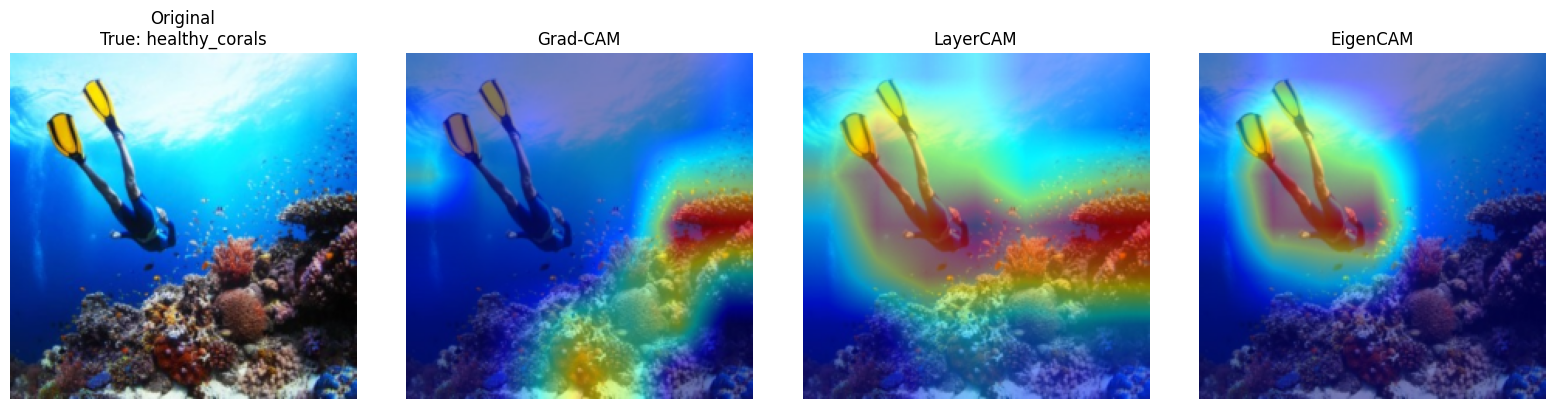

In [ ]:
img_tensor, label = test_dataset[indices[0]]

# Visualize with all interpretability methods
visualize_single_image_interpretability(img_tensor, label, model, class_names)

In reviewing the above image, it appears that Grad-CAM correctly identifies the main portion of coral. It takes this dark portion of coral and interprets it to be the main feature explaining why this is classified as a healthy coral.

It is interesting then, that despite LayerCAM serving as a technique that, using element-wise multiplication, would theoretically serve to illuminate sharper areas of focus, broadens the heatmap in this instance. Perhaps the image of the diver obscures the explainability, as they are highlighted in each of the latter two images in the series.

Finally, EigenCAM is incredibly interesting in that it almost confirms the basis of the classification, which pertains to the diver and not the coral. It's interesting that there is such disparity in the important section based on techniques.

## Image 2

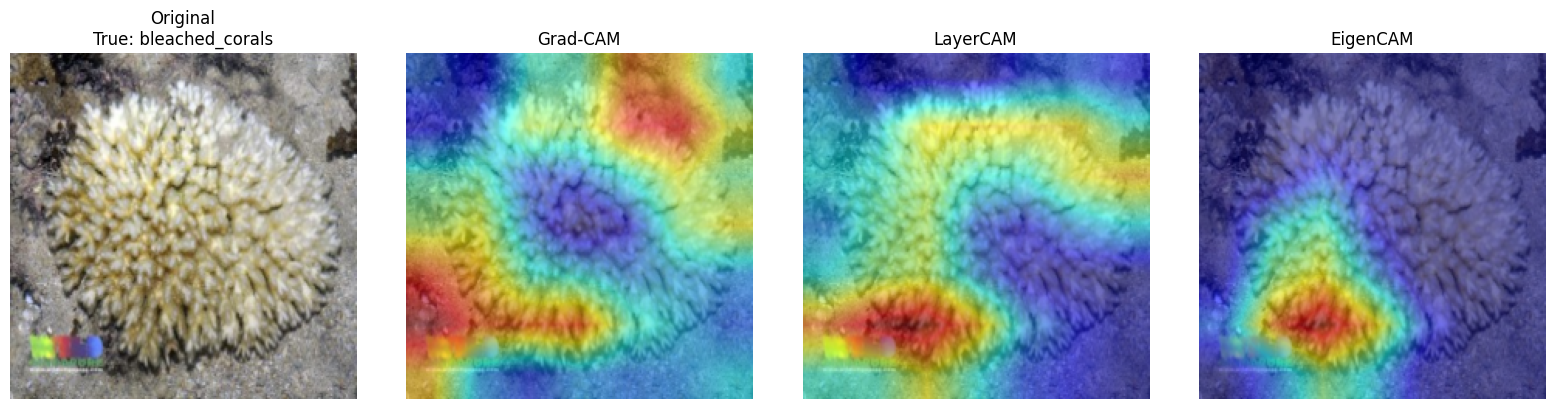

In [ ]:
img_tensor, label = test_dataset[indices[1]]

# Visualize with all interpretability methods
visualize_single_image_interpretability(img_tensor, label, model, class_names)

This interpretation of this bleached coral is really interesting because it appears that all 3 techniques converge on a particular area. It appears that the darkened portion of the coral informs the bleached designation.

GradCAM appears to recognize both diagonal corners of the coral, and perhaps this is due to the averaged gradients associated with the darker areas.

LayerCAM is supposed to be more refined in its interpretation, so it is interesting that the red area takes on a diamond shape. This crisp shape suggests that it is perceptive to the specific areas at which the coral is darkened.

I am perhaps most confident in EigenCAM because of its interpretation using PCA. Taking the first component, it appears that the same area is highlighted as the most important portion of the coral to inform the decision.

## Image 3

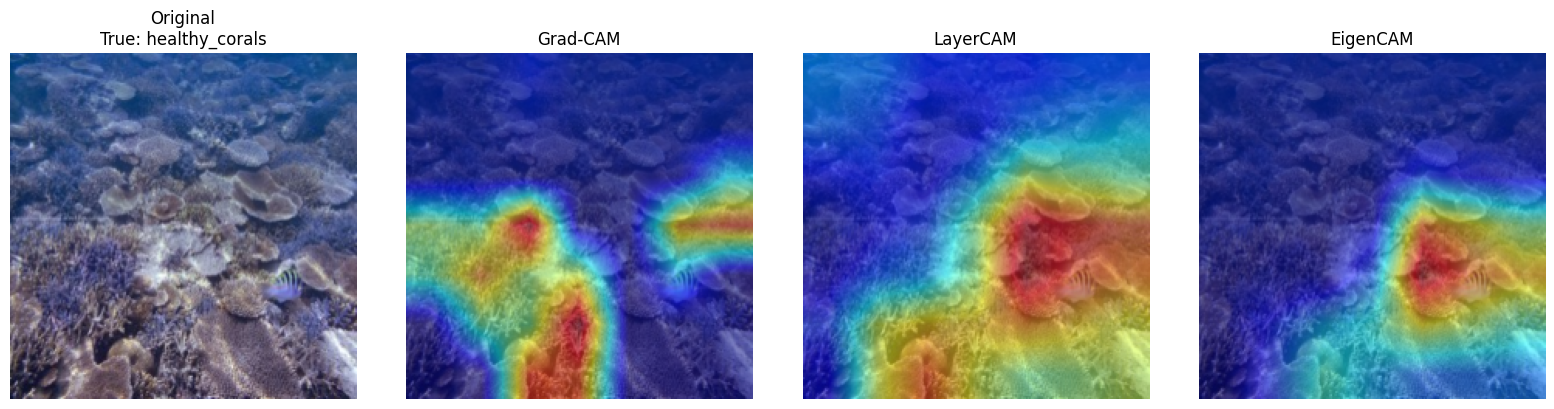

In [ ]:
img_tensor, label = test_dataset[indices[2]]
visualize_single_image_interpretability(img_tensor, label, model, class_names)

This picture feels incredibly difficult to classify, given the limited presence of color, but it appears that LayerCAM is able to pick up on this image well due to the large region highlighted as significant in decision-making.

This region does not appear to be highlighted for GradCAM, and instead GradCAM highlights what I would have expected to be the most important feature area: the purple coral.

Instead, LayerCAM focuses on a portion of coral that is relatively dark, and perhaps includes black coral, yet this image is classified as a healthy coral section by ResNet. Consistently, however, we see that the shape LayerCAM highlights is incredibly rigid, given the element-wise multiplication it applies to gradients.

EigenCAM, despite not using gradients, appears to concur with this assessment of feature importance, and highlights the same using PCA.

## Image 4

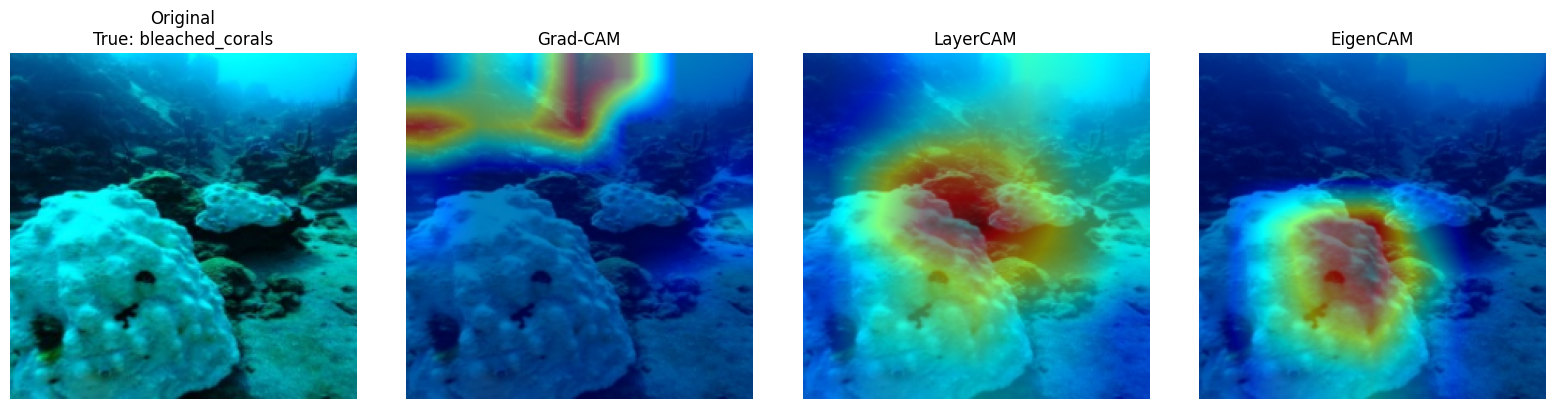

In [ ]:
img_tensor, label = test_dataset[indices[3]]
visualize_single_image_interpretability(img_tensor, label, model, class_names)

What is perhaps very fascinating is the variety of images, and image quality, that the model has to sift through. In this case, this image perhaps offers less sharpness than the others, making it tougher to classify.

In this case, I believe the low resolution of the image may have led GradCAM to assign an incorrect region of the picture with high importance. It picks perhaps some dark coral in the background, but that area is just difficult to even perceive properly given the distance.

Instead, LayerCAM and EigenCAM both end up focusing on perhaps the intended portion of the photo. It is difficult to tell, but perhaps the texture of the coral can offer a clue into its health - the mushy nature of the coral in front could indicate bleached coral, and so imaging such as the above picture can be interpreted by models to accurately identify based on perceived texture. In the case of LayerCAM, it hones in once again on a dark stretch of coral in the middle to inform the decision, which may not be the intended region.

## Image 5

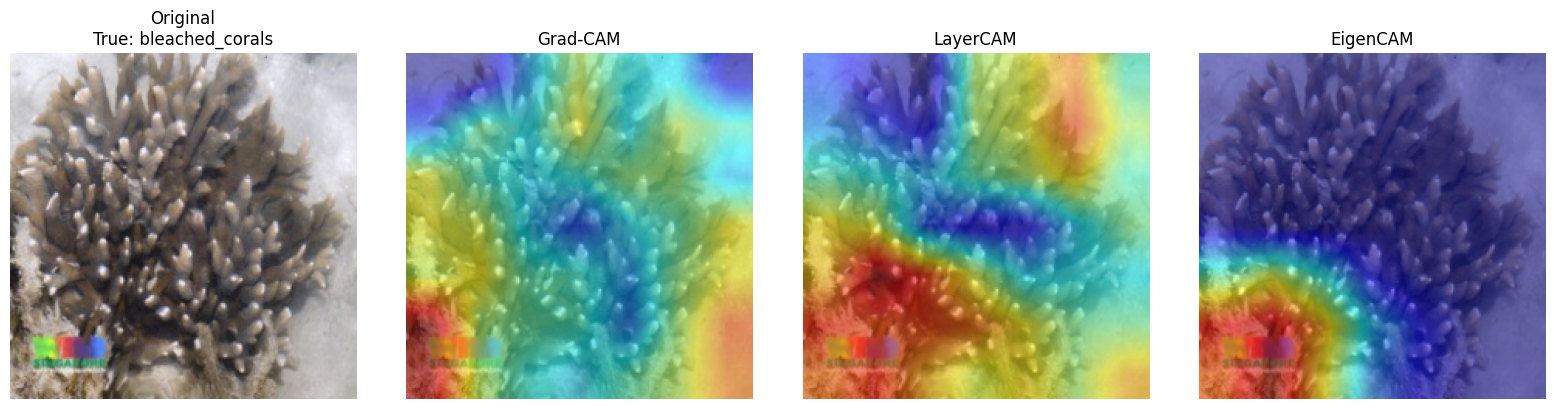

In [ ]:
img_tensor, label = test_dataset[indices[4]]
visualize_single_image_interpretability(img_tensor, label, model, class_names)

This image perhaps offers the best opportunity to evaluate the three explainability criteria, given the zoomed-in nature of the image.

GradCAM highlights the lower exterior portions of the coral, which may refer to the lighter portions of the coral. Given that the predicted class is bleached coral, it appears to apply positive attention to show that these areas were the portions which steered the direction in favor of bleached coral the most.

LayerCAM identifies a similar portion, but expands it more widely. Again, the region highlighted by LayerCAM appears to be sharper, likely due to a more detailed gradient element-wise multiplication applied. This perhaps can better capture the texture associated with the coral.

Finally, EigenCAM also finds that that the lower left corner exerts the most influence in favor of a bleached classification. What I find interesting is that while GradCAM highlights almost the entire map in some color, showing how even the middle portions influence the decision to a lesser degree, EigenCAM is incredibly refined and limited to a particular region, in particular the lower left-hand corner.